In [2]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader


In [3]:
IMG_SIZE = 128
BATCH_SIZE = 32
EPOCHS = 20
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])


In [4]:
class ImageDataset(Dataset):
    def __init__(self, folder_path, image_ids, transform=None):
        self.folder_path = folder_path
        self.image_ids = image_ids
        self.transform = transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_name = self.image_ids[idx]
        img_path = os.path.join(self.folder_path, img_name)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, img_name


In [5]:
train_df = pd.read_csv("train_labels.csv")
train_ids = train_df['image_id'].tolist()

train_dataset = ImageDataset("train", train_ids, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [6]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # [16, 64, 64]
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),  # [32, 32, 32]
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),  # [64, 16, 16]
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),  # [32, 32, 32]
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),  # [16, 64, 64]
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),  # [1, 128, 128]
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = Autoencoder().to(DEVICE)


In [7]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for imgs, _ in train_loader:
        imgs = imgs.to(DEVICE)
        output = model(imgs)
        loss = criterion(output, imgs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss/len(train_loader):.4f}")


Epoch 1/20, Loss: 0.0481
Epoch 2/20, Loss: 0.0120
Epoch 3/20, Loss: 0.0076
Epoch 4/20, Loss: 0.0067
Epoch 5/20, Loss: 0.0061
Epoch 6/20, Loss: 0.0055
Epoch 7/20, Loss: 0.0052
Epoch 8/20, Loss: 0.0048
Epoch 9/20, Loss: 0.0046
Epoch 10/20, Loss: 0.0044
Epoch 11/20, Loss: 0.0042
Epoch 12/20, Loss: 0.0042
Epoch 13/20, Loss: 0.0041
Epoch 14/20, Loss: 0.0040
Epoch 15/20, Loss: 0.0039
Epoch 16/20, Loss: 0.0039
Epoch 17/20, Loss: 0.0038
Epoch 18/20, Loss: 0.0037
Epoch 19/20, Loss: 0.0037
Epoch 20/20, Loss: 0.0036


In [8]:
test_ids_df = pd.read_csv("test_ids.csv")
test_ids = test_ids_df['image_id'].tolist()

test_dataset = ImageDataset("test", test_ids, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

model.eval()
reconstruction_errors = []
image_names = []

with torch.no_grad():
    for img, name in tqdm(test_loader):
        img = img.to(DEVICE)
        output = model(img)
        loss = torch.mean((output - img) ** 2).item()
        reconstruction_errors.append(loss)
        image_names.append(name[0])


100%|████████████████████████████████████████████████████████████████████████████████| 967/967 [00:12<00:00, 78.49it/s]


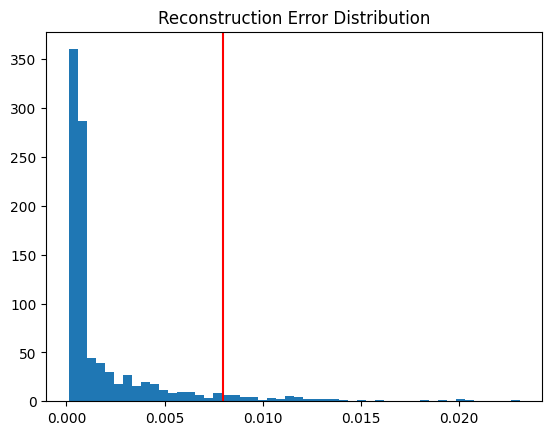

In [9]:
# Use 95th percentile threshold
threshold = np.percentile(reconstruction_errors, 95)

# Predict: 1 = Soil, 0 = Non-soil
predictions = [1 if e < threshold else 0 for e in reconstruction_errors]

# Optional: Visualize
plt.hist(reconstruction_errors, bins=50)
plt.axvline(threshold, color='red')
plt.title("Reconstruction Error Distribution")
plt.show()


In [11]:
submission = pd.DataFrame({
    "image_id": image_names,
    "label": predictions
})
submission.to_csv("Submission_v2.csv", index=False)
print("✅ Submission_v2.csv saved")


✅ Submission_v2.csv saved
